# Bayesian Inference Tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In this tutorial we'll cover:

    1) Probability Distributions.
    2) The sum and product rules of probability theory.
    3) The interpretation of likelihoods, posteriors and priors.
    4) An analytic implementation of simple Bayesian inference.
    5) Hierarchical Bayesian models.
    6) Probabilistic graphical models.
    7) A numerical implementation of a hierarchical Bayesian model.

Dependencies: you'll need to make sure you've got numpy and matplotlib installed in order to run this notebook. To install daft, type 'pip install daft' in your command line.

# 8 reasons to use Bayesian inference

    1) You want to infer the properties of some physical process by fitting a model to data.
    2) When fitting a model to data you want to be explicit about your assumptions.
    3) You'd like to produce probability distributions over model parameters.
    4) Your problem is slightly more complicated that the simplest case.
    5) E.g. you have a hierarchical model.
    6) You'd like to compare alternative models.
    7) You're working at the edge of observability.
    8) Frequentist statistics are Hard.

# Probability Distributions

A probability is the chance of a certain event x occurring. The frequentist way to measure a probability is to ask how many times event x occurred out of a number of trials. The probability is then the number of times the outcome was x divided by the number of trials.

For discrete variables this is simple: e.g. to calculate the probability of a coin landing heads-up you would divide the number of time you got heads by the total number of coin tosses.

But once you start to consider continuous variables: e.g. what is the probability that a person weighs between 170 and 173cm, you start having to perform integrals.

Inference is all about solving integrals.

#  Breads & spreads

Joint, marginal and conditional probabilities

🥑, 🍞, 🥛🧀, 🍩


 |   |🍩| 🍞| 
 |---|---|---|
 | 🥛🧀| 5 | 1 |
 | 🥑| 3 | 7 |

A __joint__ probability is the probability of more than one thing. For example, your friend goes out to buy two ingredients for breakfast sandwiches: bread, X and spread, Y from a shop that only sells toast, bagels, avocado and cream cheese. You forgot to mention to your friend that you _really_ like bagels and cream cheese. You're hoping they'll bring bagels and cream cheese. If the probability of your friend buying bagels is $p(X = 🍩)$ and the probability of them buying cream cheese is $p(Y = 🥛🧀)$, then the joint probability of your friend buying both bagels and cream cheese is $p(X = 🍩, Y = 🥛🧀)$. This is a joint probability. Both bagels _and_ cream cheese would be a win.

__Marginal__ probabilities are the probabilities we talk about most often. It's the probability of a single outcome where you ignore other outcomes that are related. For example, you might say "what's the chance of rain today?". The chance of rain is a marginal probability since the rain probability distribution is related to the humidity probability distribution and the pressure probability distribution, etc.

If you ask Siri for the chance of rain she will tell you "there is a 40% chance of rain today". She has got that information from a weather prediction algorithm that has inferred the probability distribution of rain, marginalizing over the probability distributions of clouds, wind, temperature, and more.

Let's go back to the bagel example. Really you only want the bagels because you love cream cheese. To be honest, you'd probably eat cream cheese on anything. What you really care about is whether your friend brings you cream cheese and you're not interested in whether they bring bagels. 

The probability that your friend brings back cream cheese, regardless of whether they bring back bagels is the probability of cream cheese, marginalized over the probability distribution over possible bread (X) values. If you want to know the total probability of cream cheese being part of your near future you need to add together the probabilities of cream cheese if $X=🍩$ and the probability if $X=🍞$.

If the probability of cream cheese doesn't depend on X, then Y is not conditionally dependent on X and the probability of cream cheese becomes, $p(Y = 🥛🧀|X) = p(Y = 🥛🧀)$.

But the probability of cream cheese almost certainly does depend on the choice of bread, in which case you'll need to marginalize over the probability distribution of X to find the probability of cream cheese:

For discrete variables this marginalization is $p(Y = 🥛🧀) = p(Y=🥛🧀|X=🍩) + p(Y=🥛🧀|X=🍞)$ or 
$ \sum_{i=1}^L p(Y=🥛🧀|X_i)$, where L is the number of bread choices.

For continuous variables this marginalization becomes an integral. $p(Y) = \int p(Y, X)dX$.

A __conditional__ probability is one where the probability of one thing depends on another thing. For example, what is the chance of rain given that it is cloudy? Or what is the chance of cream cheese given bagels?

Perhaps just as your friend was leaving you remembered to shout out, "bagels! Get bagels!". So you know you're getting bagels. Now you want the conditional probability of $Y=🥛🧀$, given that $X=🍩$. There's still a chance your friend will get avocado instead of cream cheese. It would be CRAZY but it's possible.

You want to know the probability $Y=🥛🧀$ given $X=🍩$, 

$$p(Y=🥛🧀|~X=🍩)$$

This is the marginal probability of cream cheese given bagels, or the probability of cream cheese, conditioned on the bread being bagels, $X=🍩$.

# Bayes Rule

In data analysis it's useful to write these equations in terms of data and model parameters. Ultimately, when fitting a model to data you're asking the question "Which model parameters best reproduce these data points?". You want the probability distributions over your model parameters, conditioned on the data you observe.

Say you want to fit a straight line to some data. Your model parameters are $m$ and $b$ and your data are $N$ $x$ and $y$ values: $X = \{x_1, x_2, ..., x_N\}$ and $Y = \{y_1, y_2, ..., y_N\}$.

You want the probability distribution over model parameters m and b given data $X$ and $Y$.

$$P(m, b | X, Y)~~~~~~~~~1.$$

It might be even more useful to end up with a probability distribution over each model parameter, $P(m|X, Y)$ and $P(b|X, Y)$. As we'll see shortly, to calculate these we'll need to integrate over the probability distribution in the other dimension, or 'marginalize'.

Notice that this is a conditional probability distribution. It wouldn't be very useful to have the joint probability of the data and the model, $P(m, b, X, Y)$. Writing probabilities as conditionals allows us to draw useful information out of these problems and make inferences about the world. It's also a natural outcome of any physical process. Physics (m and b) produces data (X and Y). We observe the data and use statistics to infer the physics.

Using the product rule we can write 1 as, 

$$P(m, b|X, Y) = \frac{P(m, b, X, Y)}{P(X, Y)}~~~~~~2.$$

The joint probability of the data and the model doesn't tell us very much about the model. It's much more useful to rewrite equation 2 with a second conditional probability.

Bayes' rule is:

$$P(m, b|X, Y) = \frac{P(X, Y|m, b)~P(m)P(b)}{P(X, Y)}$$

and it can be derived from the product rule of probability theory. Try to derive this equation now. Hint: the joint probability of $m, b, X, Y$, can be written in any order.

Let's write $\theta$ for the model parameters instead of m and b and D for the data instead of X and Y to simplify things. Bayes rule is,

$$P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}$$

Each of these terms has a name and interpretation.


$P(\theta)$ is the prior probability distribution. It represents your prior belief about the probability distribution over model parameters, before you have any data. You can update this prior belief once you have data, to get a posterior probability distribution over model parameters.

$P(\theta|D)$ is the posterior probability distribution. It's the probability distribution over model parameters, given the data you observe.

$P(D|\theta)$ is the likelihood. It's the probability distribution over the data you observe, given the model parameters. In other words it's the probability that you obtained the data set you have, given the model.

$P(D)$ is the probability distribution over the data. It's the probability that you observed that data set. It's also sometimes called the evidence or the fully marginalized likelihood.

# The likelihood explained

What does "the probability of your data, given the model" actually mean?

Well, say you're observing a physical process that generates data with a Gaussian probability distribution, i.e. the probability of observing a certain value is a Gaussian centered on the "truth" with a standard deviation equal to its uncertainty. If there were a large number of outliers this might not be a good assumption. We'll also assume that the data are independent and identically distributed (iid). This means that the probability distribution of each data point doesn't depend on any other data point and that the probability distribution of each data point is identical. These assumptions are implicitly being made whenever a Gaussian likelihood function is used.

The likelihood gives the probability that you observed the data you have, given the model parameters m and c. A Gaussian likelihood function for a single data point looks like this,

$$\mathcal{L_i} = p(y_i|m, c, x_i, \sigma_y) = \frac{1}{\sigma_y\sqrt{2\pi}}\exp\left(\frac{-[(mx_i + c) - x_i]^2}{2\sigma_y^2}\right)$$

Exercise: write a function for a Gaussian distribution as a python lambda function. This will come in useful throughout the tutorial.

# The evidence explained

The evidence is the probability of the data. That's it. The overall probability of observing the data. It's the total probability of the data no matter what the model parameters are: independent of them. To calculate this you must sum the total probability of the data up over every possible model parameter value, i.e. marginalize over all model parameters.

$p(D)$ can also be written, 
$$\int p(D|\theta)p(\theta)d\theta$$

In the line fitting example this would be, 
$$p(Y) = \int p(Y|m, c)p(m)p(c)dm dc$$

The evidence or fully marginalized likelihood is the normalization of the posterior PDF. If you don't calculate this you can't know the overall probability of the model given the data, you can only know the relative probability of one set of model parameters vs another. This is often all we need to know for most inference problems. The evidence/FML is useful if you want to compare one model with another, e.g. a straight line vs a 2nd order polynomial (although there is a simpler way to do this than calculating the evidence/FML -- ask me about nested models).

For a given model choice, the FML gives you the probability of seeing these data under your choice of model. If the evidence is low you know that this model does not describe the data very well. 

# Bayes rule example: playing cards

Example from [Tiny Heero - Bayes Rule](http://tinyheero.github.io/2016/04/21/bayes-rule.html)
 who got it from [Brilliant - Bayes' Theorem and Conditional Probability](https://brilliant.org/wiki/bayes-theorem/).

Say you're playing cards and you want to know your chance of drawing a king from a freshly shuffled deck. You know a priori that the chance of drawing a king is $\frac{1}{13}$.

Now you are given a piece of information (data) that the top card is a face card. What is the chance that that card is a king now? What is your updated, posterior belief about the value of that card given the data -- that it's a face card.

We can answer this question using Bayes' rule.

$$P(\theta = \mathrm{King}~|~D = \mathrm{face~card}) = \frac{P(D = \mathrm{face~card}~|~\theta = \mathrm{King})~P(\theta = \mathrm{King})}{P(D=\mathrm{face~card})} $$

We know the likelihood that the card is a face card given that it's a King: it must be 1. The probability of drawing a King is one in thirteen and the probability that the card is a face card is $\frac{12}{52}$ = $\frac{3}{13}$.

So the updated, posterior probability that you draw a king given that you know the card is a face card is,

$$P(\theta = \mathrm{King}~|~D = \mathrm{face~card}) = \frac{1 \times \frac{1}{13}}{\frac{3}{13}} = \frac{1}{3}$$

A frequentist might answer this question by repeated trials. They would divide the number of times the card was a King  and also a face card by the number of times the card was a face card. After infinite trials they would find the probability to be exactly $\frac{1}{3}$.

# A simple example

Fitting a line to data.

Here are some data generated by some deterministic process. There is a model that relates X to Y and Y is fully determined by X and some noise property, $\sigma_Y$.

Draw a probabilistic graphical model for this problem.

Text(0,0.5,'y')

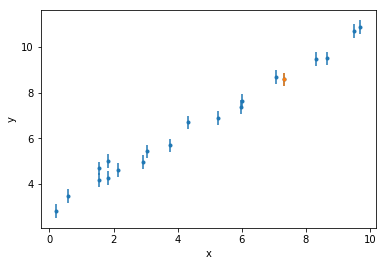

In [61]:
N = 20
op = 2

np.random.seed(42)
x = np.random.uniform(0, 10, size=N)
sigma = .3  # Homoskedastic uncertainties, all uncerts take this value.
yerr = np.ones_like(x) * sigma

# make up a model
m, c = .8, 3
y = m * x + c + np.random.randn(N) * sigma
plt.errorbar(x, y, yerr=yerr, fmt=".")
plt.errorbar(x[op], y[op], yerr[op], fmt=".")  # highlight one data point in orange
plt.xlabel("x")
plt.ylabel("y")

We can write Bayes rule as, 

$$p(m, c| \{y_i\}_{i=1}^N, \{x_i\}_{i=1}^N, \sigma_y ) \propto p(\{y_i\}_{i=1}^N | m, c, \{x_i\}_{i=1}^N, \sigma_y) p(m)p(c)$$

To make this more readable, we'll drop the $x$ and $\sigma$,

$$p(m, c| \{y_i\}_{i=1}^N) \propto p(\{y_i\}_{i=1}^N | m, c) p(m)p(c)$$

If the probability of observing a certain y-value is a Gaussian centered on the "truth" with a standard deviation equal to its uncertainty, then we can use a Gaussian likelihood function for this inference problem. If there were a large number of outliers (i.e. the data were not Gaussian distributed) this might not be a good assumption. We'll also assume that the data are independent and identically distributed (iid). This means that the probability distribution of each data point doesn't depend on any other data point and that the probability distribution of each data point is identical. These assumptions are implicitly being made whenever a Gaussian likelihood function is used.

What's the likelihood of that orange data point? As in, what's the likelihood of observing that data point, given the model, y = mx + c, and the chosen x value? The coordinates of that data point are:

In [62]:
print(x[op], y[op])

7.319939418114051 8.583544311834876


The likelihood is:

$$\mathcal{L} = p(y_2|m, c, x_2, \sigma_y) = \frac{1}{(2\pi\sigma_y^2)^{N/2}}\exp\left[-\frac{1}{2\sigma_y^2}(y_2 - \mu)^2 \right]$$

Here $\mu$ is the mean. We're used to thinking of the mean as a single number. But here we're saying that each data point is drawn from a Gaussian distribution __centered on the straight line__. The straight line is the mean and since it's a model instead of a number we'll call it the mean model. So $\mu = mx + b$.

$$ = \frac{1}{(2\pi\sigma_y^2)^{N/2}}\exp\left[-\frac{1}{2\sigma_y^2}(y_2 - [mx_2 + c])^2 \right]$$

Plug in the numbers to calculate the likelihood of that data point. Define a variable equal to that likelihood and call the variable yop_likelihood.

Q: Why can this value be greater than 1?

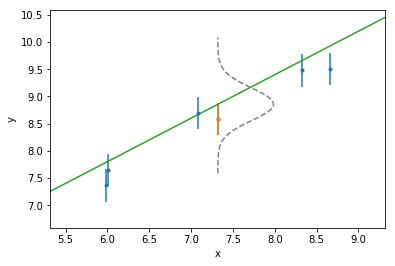

In [63]:
plt.errorbar(x, y, yerr=yerr, fmt=".")
plt.errorbar(x[op], y[op], yerr[op], fmt=".")  # highlight one data point in orange

xplot = np.linspace(0, 10, 100)
plt.plot(xplot, m*xplot + c)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(x[op]-2, x[op]+2)
plt.ylim(y[op]-2, y[op]+2)

yplot = np.linspace(y[op]-1, y[op]+1.5, 100)
plt.plot((Gauss((m*x[op] + c), sigma, yplot))*.5 + x[op], yplot, ".5", ls="--");

The probability distribution over y-values, given the model and the x value is shown by the grey, dashed Gaussian shape. Here it is on its own.

8.583544311834876 0.8805402937501676


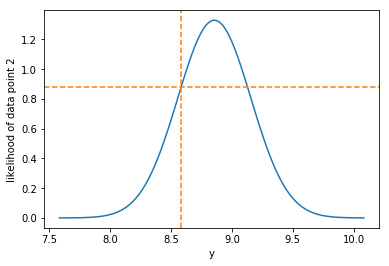

In [64]:
plt.plot(yplot, Gauss((m*x[op] + c), sigma, yplot))
plt.ylabel("likelihood of data point 2")
plt.xlabel("y")
plt.axvline(y[op], color="tab:orange", ls="--")
plt.axhline(yop_likelihood, color="tab:orange", ls="--");
print(y[op], yop_likelihood)

The orange line is the observation. This line intersects the curve at the likelihood calculated above. What happens if the values of the model parameters change?

(6.583544311834876, 10.583544311834876)

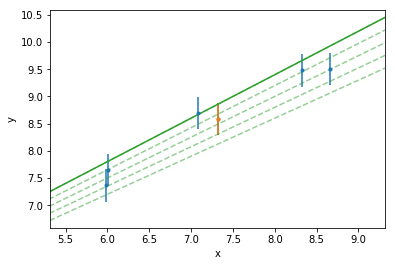

In [65]:
plt.errorbar(x, y, yerr=yerr, fmt=".")
plt.errorbar(x[op], y[op], yerr[op], fmt=".")  # highlight one data point in orange

# Plot lines with different slopes
ms = np.linspace(m, m-.1, 5)
for mi in ms:
    plt.plot(xplot, mi*xplot + c, color="tab:green", alpha=.5, ls="--")
    
plt.plot(xplot, m*xplot + c, color="tab:green")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(x[op]-2, x[op]+2)
plt.ylim(y[op]-2, y[op]+2)

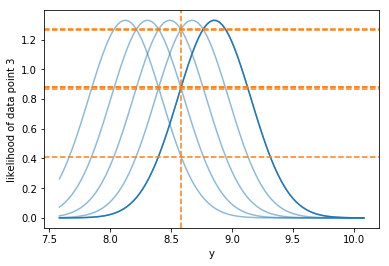

In [66]:
# Plot the likelihood of the orange data point for models with different slopes
for mi in ms:
    plt.plot(yplot, Gauss((mi*x[op] + c), sigma, yplot), alpha=.5, color="tab:blue")

plt.plot(yplot, Gauss((m*x[op] + c), sigma, yplot), color="tab:blue")
plt.ylabel("likelihood of data point 3")
plt.xlabel("y")
plt.axvline(y[op], color="tab:orange", ls="--")
plt.axhline(yop_likelihood, color="tab:orange", ls="--")

for mi in ms:
    plt.axhline(Gauss((mi*x[op] + c), sigma, y[op]), color="tab:orange", ls="--")

Let's plot the likelihood of this data point as a function of various values for the slope.

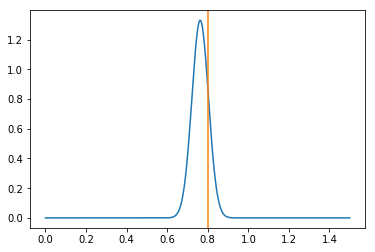

In [67]:
mgrid = np.linspace(0, 1.5, 1000)
m_dist = Gauss((mgrid*x[op] + c), sigma, y[op])

plt.plot(mgrid, m_dist)
plt.axvline(m, color="tab:orange")

Why isn't the maximum of this distribution 0.8?

[0.76276276]


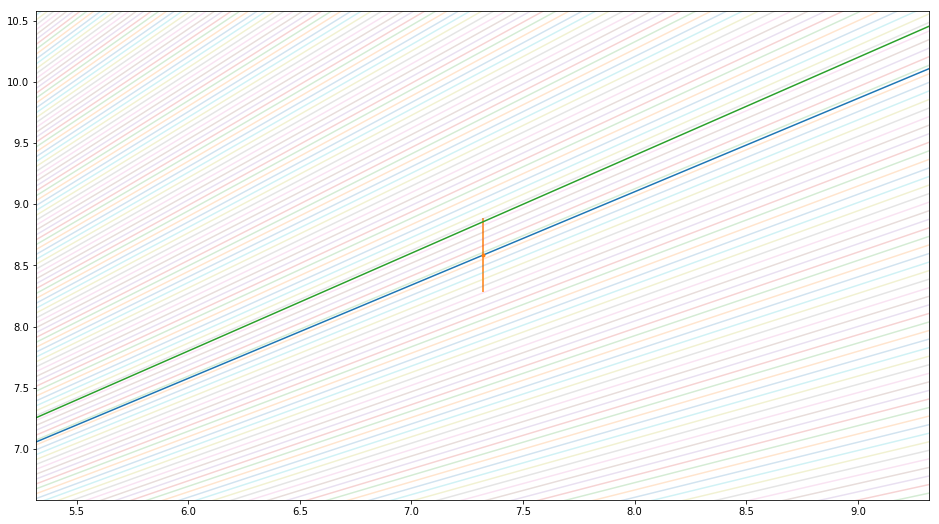

In [69]:
plt.figure(figsize=(16, 9))
for ms in mgrid[::5]:
    plt.plot(xplot, ms*xplot + c, alpha=.2)
plt.plot(xplot, m*xplot + c, "tab:green")
plt.errorbar(x[op], y[op], yerr=yerr[3], fmt=".", color="tab:orange")
plt.xlim(x[op]-2, x[op]+2)
plt.ylim(y[op]-2, y[op]+2)

max_m = mgrid[m_dist == max(m_dist)]
print(max_m)
plt.plot(xplot, max_m*xplot + c, "tab:blue")

How about the likelihood of all the data, given the model? This is just the product of likelihoods for the individual data points.

$$\mathcal{L} = p(\{y_i\}_{i=1}^N|m, c) = \prod_{i=1}^Np(y_i|m, c)$$

Calculate the total likelihood of all the data in the cell below.

In practise this number can get very small so it is usually more convenient to work with the log likelihood, 

$$\ln(\mathcal{L}) = \ln\left[p(\{y_i\}_{i=1}^N|m, c)\right] = \sum_{i=1}^N \ln \left[ p(y_i|m, c)\right]  $$

Calculate the log likelihood in the cell below.

Now let's look at the likelihood of all the data, given a range of model parameters, m and c.

Use the cell below to define a log-likelihood function (not as a lambda function, just a regular function). This function should take the list of parameters [m, c], x, y and yerr as arguments and return the total log-likelihood.

In [15]:
ngrid_m = 100
ngrid_c = 200
mmin, mmax, cmin, cmax = .6, 1, 2, 4
_M, _C = np.linspace(mmin, mmax, ngrid_m), np.linspace(cmin, cmax, ngrid_c)
M, C = np.meshgrid(_M, _C, indexing="ij")

lnlikes = np.zeros((ngrid_m, ngrid_c))
for i in range(ngrid_m):
    for j in range(ngrid_c):
        par = [M[i, j], C[i, j]]
        lnlikes[i, j] = lnlike(par, x, y, yerr)

Plot the resulting 2d distribution.

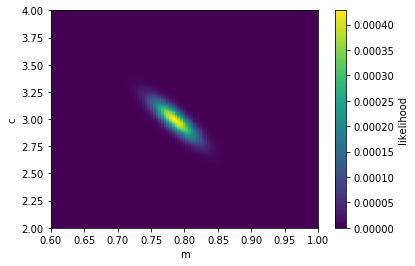

In [16]:
plt.pcolor(_M, _C, np.exp(lnlikes.T))
plt.colorbar(label="likelihood")
plt.xlabel("m")
plt.ylabel("c");

Plot the marginals.

In [ ]:

plt.xlabel("m");

In [ ]:

plt.xlabel("c");

What about the prior?

Reminder: Bayes rule is.

$$p(\theta|D) = \frac{p(D|\theta) p(\theta)}{p(D)}$$

$$p(m, c|\{y_i\}_{i=1}^N) \propto p(\{y_i\}_{i=1}^N|m, c) p(\theta)$$

$$ \mathrm{posterior} \propto \mathrm{likelihood} \times \mathrm{prior}$$

So, in order to calculate the posterior we need to multiply the likelihood by a prior. We're using a Gaussian likelihood function and if we also use a Gaussian prior, we can calculate the posterior analytically because a Gaussian multiplied by a Gaussian is another Gaussian.

Let's define some broad priors over the model parameters. Complete the following function.

In [19]:
def prior(par):
    m, c = par
    
    # A Gaussian prior over m, with standard deviation = 0.5, and mean = 1
    
    # A Gaussian prior over c, with standard deviation = 1 and mean = 3
    
    return 

And evaluate the prior everywhere we evaluated the likelihood.

In [20]:
priors = np.zeros((ngrid_m, ngrid_c))
for i in range(ngrid_m):
    for j in range(ngrid_c):
        par = [M[i, j], C[i, j]]
        priors[i, j] = prior(par)

Plot the 2D distribution and the marginals

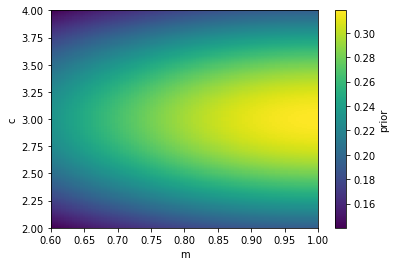

In [21]:
plt.pcolor(_M, _C, priors.T)
plt.colorbar(label="prior")
plt.xlabel("m")
plt.ylabel("c");

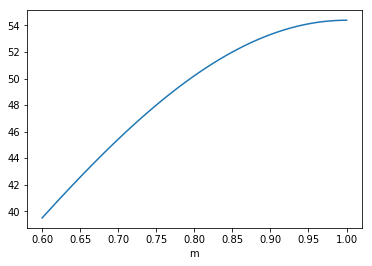

In [22]:
plt.plot(M[:, 0], np.sum(priors, axis=1));
plt.xlabel("m");

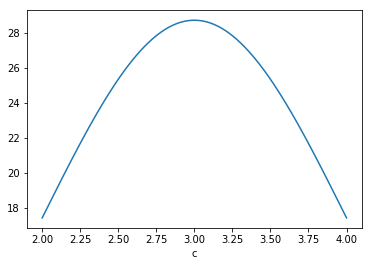

In [23]:
plt.plot(C[0, :], np.sum(priors, axis=0));
plt.xlabel("c");

Now calculating the posterior is as easy as multiplying the likelihood by the prior. Go ahead!

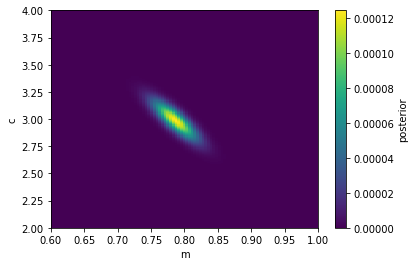

In [25]:
plt.pcolor(_M, _C, posterior.T)
plt.colorbar(label="posterior")
plt.xlabel("m")
plt.ylabel("c");

Let's plot the marginals again

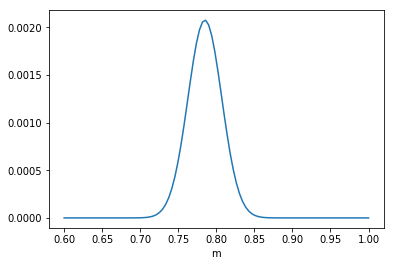

In [26]:
plt.plot(M[:, 0], np.sum(posterior, axis=1));
plt.xlabel("m");

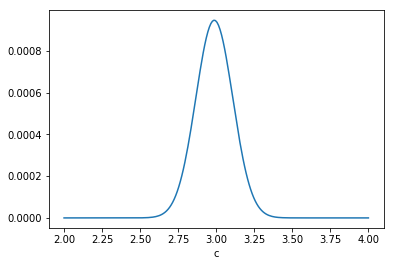

In [27]:
plt.plot(C[0, :], np.sum(posterior, axis=0));
plt.xlabel("c");

Even though my prior over m was a little bit wrong, it didn't matter because the data strongly support the correct model.

This posterior is proportional to a new Gaussian:

$$p(m, c, \{x_i\}_{i=1}^N, \sigma_y|\{y_i\}_{i=1}^N) \propto \frac{1}{\sigma_y\sqrt{2\pi}} \prod_{i=1}^N \exp\left(-\frac{[(m\{x_i\}_{i=1}^N + c) - \{y_i\}_{i=1}^N]^2}{2\sigma_y^2}\right) \frac{1}{\sigma_m\sqrt{2\pi}} \exp\left( - \frac{(\mu_m - m)^2}{2\sigma_m^2} \right) \frac{1}{\sigma_c\sqrt{2\pi}} \exp\left( - \frac{(\mu_c - c)^2}{2\sigma_c^2} \right)$$

and if we took the derivative of this Gaussian with respect to the model parameters we'd be able to calculate the normalised posterior.

$$p(m, c|\{y_i\}_{i=1}^N) = \frac{\frac{1}{\sigma_y\sqrt{2\pi}} \prod_{i=1}^N \exp\left(-\frac{[(m\{x_i\}_{i=1}^N + c) - \{y_i\}_{i=1}^N]^2}{2\sigma_y^2}\right) \frac{1}{\sigma_m\sqrt{2\pi}} \exp\left( - \frac{(\mu_m - m)^2}{2\sigma_m^2} \right) \frac{1}{\sigma_c\sqrt{2\pi}} \exp\left( - \frac{(\mu_c - c)^2}{2\sigma_c^2} \right)}  {\int_{-\infty}^\infty \frac{1}{\sigma_y\sqrt{2\pi}} \prod_{i=1}^N \exp\left(-\frac{[(m\{x_i\}_{i=1}^N + c) - \{y_i\}_{i=1}^N]^2}{2\sigma_y^2}\right) \frac{1}{\sigma_m\sqrt{2\pi}} \exp\left( - \frac{(\mu_m - m)^2}{2\sigma_m^2} \right) \frac{1}{\sigma_c\sqrt{2\pi}} \exp\left( - \frac{(\mu_c - c)^2}{2\sigma_c^2} \right) dm dc}$$

Since the likelihood and priors we used were Gaussian, the posterior is also a Gaussian and the evidence is an integral over a Gaussian which is analytic. It is therefore possible to calculate the posterior analytically, but that's above my pay-grade for today.

Let's plot the likelihoods of each data point.

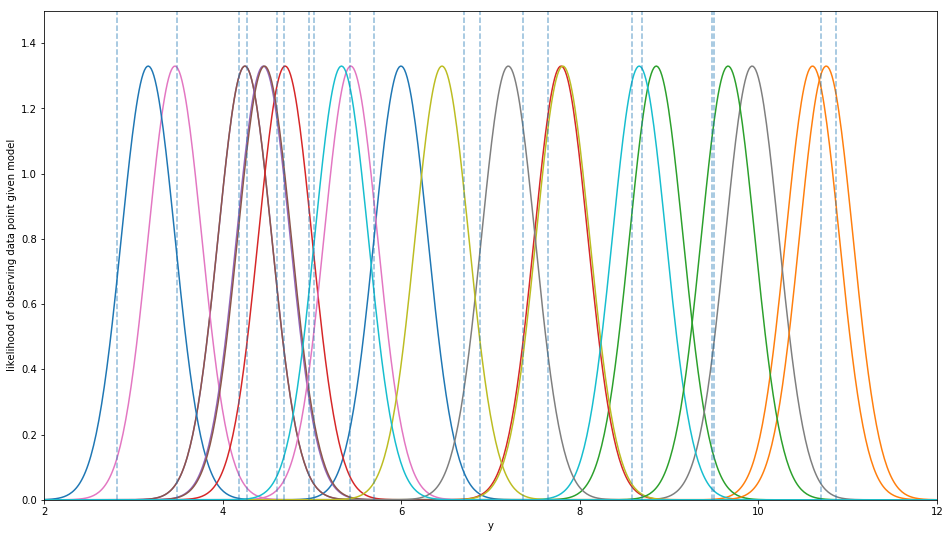

In [28]:
plt.figure(figsize=(16, 9))
yp = np.linspace(0, 15, 1000)

for xi in x: 
    plt.plot(yp, Gauss((m*xi + c), sigma, yp))

plt.ylabel("likelihood of observing data point given model")
plt.xlabel("y")
plt.xlim(2, 12)
plt.ylim(0, 1.5)

for i, yi in enumerate(y):
    plt.axvline(yi, ls="--", alpha=.5)

Why are these all the same height and width?

# Frequentism vs Bayesianism

Frequentists see probabilities as the outcomes of repeated trials, where the probability of an outcome is its frequency divided by the total number of trials. The more trials, the closer this probability gets to the true probability. In Bayesian statistics, prior beliefs about the probability of an event are incorporated into the calculation.

One of the biggest practical differences are that Bayesians are explicit about the priors they use. In a sense frequentists still have priors they're just 'improper' priors. 

The other main difference is that it isn't very meaningful to think about the probability of a single event if you're a frequentist. Frequentist probabilities represent the frequency of a certain event occurring, given a number of trials. Bayesians see the world probabilistically.

# Fitting a line to data: a fully worked example.

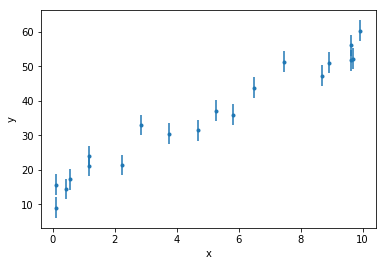

In [50]:
N = 20

x = np.random.uniform(0, 10, size=N)
y_sigma = 3  # Homoskedastic uncertainties, all uncerts take this value.
yerr = np.ones_like(x) * y_sigma

# make up a model
true_m, true_c = 4, 15
y = true_m * x + true_c + np.random.randn(N) * y_sigma
plt.errorbar(x, y, yerr=yerr, fmt=".")
plt.xlabel("x")
plt.ylabel("y");

Let's first use linear least squares fitting. This model is linear and the maximum likelihood values of the model parameters m and c can be found analytically using linear algebra.

$$y = mx + c$$

$$[c, m] = (A^T C^{-1} A)^{-1} A^T C^{-1} y$$

In [51]:
AT = np.vstack((np.ones_like(x), x))
C = np.eye(N) * y_sigma**2

ATC_invA = np.dot(AT, np.linalg.solve(C, AT.T))
ATC_invy = np.dot(AT, np.linalg.solve(C, y))
freq_c, freq_m = np.linalg.solve(ATC_invA, ATC_invy)

c_err, m_err = np.sqrt(np.diag(np.linalg.inv(ATC_invA)))

print("c = {0:.2} +/- {1:.2}, m = {2:.2} +/- {3:.2}".format(freq_c, c_err, freq_m, m_err))
print("true c = ", true_c, "true m = ", true_m)

c = 1.5e+01 +/- 1.1, m = 4.2 +/- 0.19
true c =  15 true m =  4


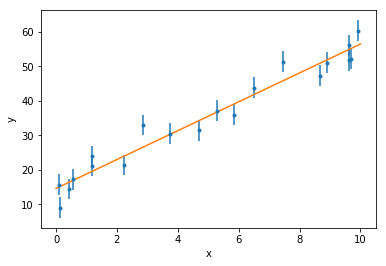

In [52]:
plt.errorbar(x, y, yerr=yerr, fmt=".")
plt.xlabel("x")
plt.ylabel("y")
xplot = np.linspace(0, 10, 100)
plt.plot(xplot, freq_m*xplot + freq_c)

But if you wanted to use a prior that doesn't bias your results toward higher slopes you could do MCMC.

In [53]:
def lnlike(par, args):
    x, y, y_sigma = args
    c, m = par
    mean_model = m*x + c
    return -.5 * sum((y - mean_model)**2 / y_sigma**2)

def lnprior(par):
    """
    From Jake Vanderplas's blog post: 
    https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
    """
    c, m = par
    return -1.5 * np.log(1 + m ** 2)

def uniform_lnprior(par):
    c, m = par
    if -10 < c < 10 and -10 < m < 10:
        return 0
    else:
        return -np.inf

def lnprob(par, *args):
    x, y, y_sigma = args
    return lnlike(par, args) + lnprior(par)

In [54]:
import emcee

ndim, nwalkers = 2, 50
p_init = 1, 1

args = [x, y, y_sigma]
p0 = [np.random.rand(ndim)*1e-4 + p_init for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=args)
p0, _, _ = sampler.run_mcmc(p0, 1000);
sampler.reset()
sampler.run_mcmc(p0, 1000);

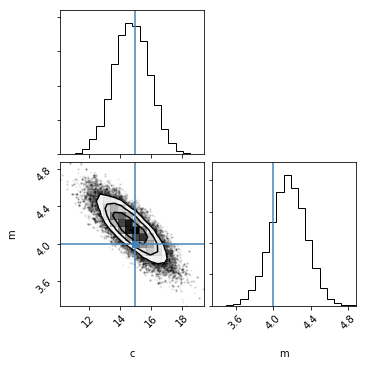

In [55]:
import corner
corner.corner(sampler.flatchain, labels=["c", "m"], truths=[true_c, true_m]);

In [56]:
c_samps, m_samps = sampler.flatchain.T
med_c, med_m = np.median(c_samps), np.median(m_samps)
c_err, m_err = np.std(c_samps), np.std(m_samps)
c_errm, c_errp = med_c - np.percentile(c_samps, 16), np.percentile(c_samps, 84) - med_c
m_errm, m_errp = med_m - np.percentile(m_samps, 16), np.percentile(m_samps, 84) - med_m

print("c = {0:.2} +/- {1:.2}".format(med_c, c_err), "m = {0:.2} +/- {1:.2}".format(med_m, m_err))
print("true c = ", true_c, "true m = ", true_m)

c = 1.5e+01 +/- 1.1 m = 4.2 +/- 0.19
true c =  15 true m =  4
